In [ ]:
#Veriyi okuma ve işleme adımında kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

#Warningleri Kapatmak İçin
import warnings
warnings.filterwarnings('ignore')

#TensorFlow Warningleri Engelleme
import os
os.environ['TF_CPP_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
df = pd.read_csv("international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.columns = ["Month","Passengers"]
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.shape
df.dtypes


Month          object
Passengers    float64
dtype: object

In [ ]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# 3)Veriyi Hazırlama

In [ ]:
df = df[:144]

In [ ]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df["Month"] = pd.to_datetime(df["Month"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [ ]:
print("Minimum Tarih:",df["Month"].min())
print("Makisimum Tarih:",df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Makisimum Tarih: 1960-12-01 00:00:00


In [ ]:
df.index=df["Month"]

In [ ]:
df.drop("Month",axis=1,inplace=True)

In [ ]:
result_df = df.copy()

<Axes: title={'center': 'Aylık Hava Yolcusu Sayısı(Monthly airline passengers)'}, xlabel='Month'>

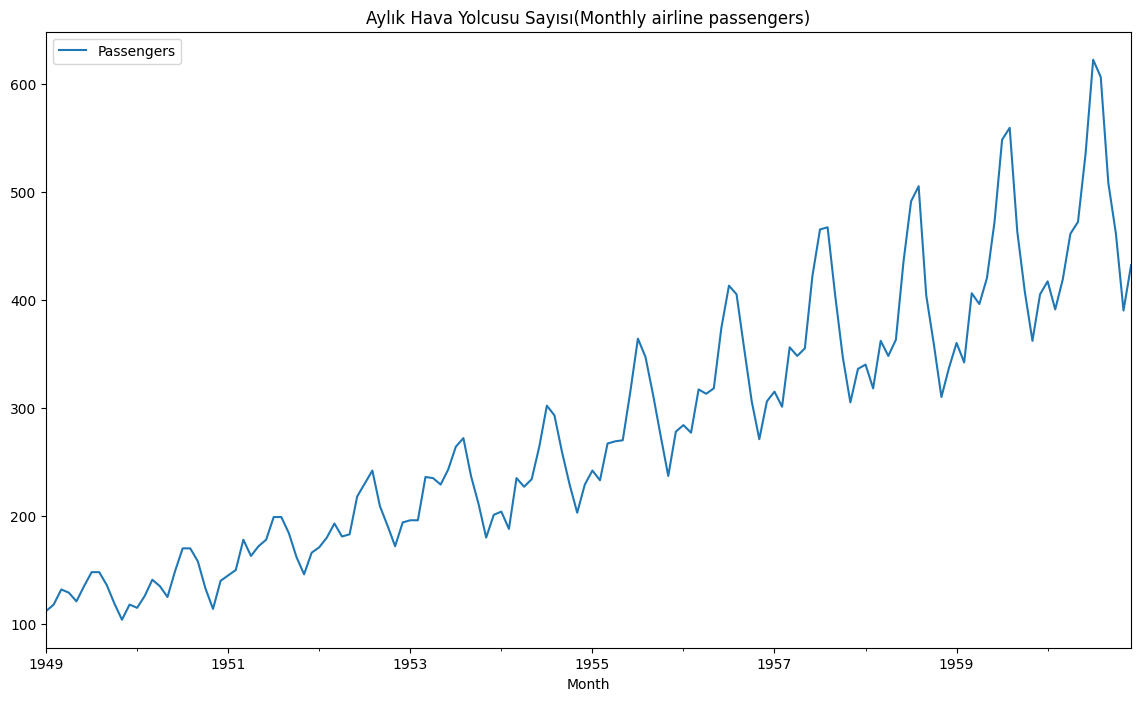

In [ ]:
df.plot(figsize=(14,8),title='Aylık Hava Yolcusu Sayısı(Monthly airline passengers)')

In [ ]:
data = df["Passengers"].values

In [ ]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [ ]:
type(data[0:5])

numpy.ndarray

In [ ]:
data = data.astype('float32')

In [ ]:
data.shape

(144,)

In [ ]:
data = data.reshape(-1,1)

In [ ]:
data.shape

(144, 1)

In [ ]:
def split_data(dataframe,test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train , test , position

In [ ]:
train , test , position = split_data(data,0.33)

In [ ]:
print(train.shape,test.shape)

(96, 1) (48, 1)


In [ ]:
scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)

In [ ]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [ ]:
def create_features(data,lookback):
  X,Y =[] ,[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [ ]:
lookback = 1

In [ ]:
#Train Veri Seti
X_train , y_train = create_features(train , lookback)

In [ ]:
#Test Veri Seti
X_test , y_test = create_features(test , lookback)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)  #Loockback yaptığımız için loockback kadar data azaldı

(95, 1) (95,) (47, 1) (47,)


In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


In [ ]:
from keras.api._v2.keras import activations
model = Sequential()

model.add(SimpleRNN(units=50,
                   activation='relu',
                   input_shape=(X_train.shape[1],lookback)))

model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


#Optimizasyon ve Değerlendirme Metrikleri

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')



In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                             save_best_only=True,save_weights_only=False,verbose=1)]

In [ ]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
80/95 [========================>.....] - ETA: 0s - loss: 0.0161
Epoch 1: val_loss improved from inf to 0.03939, saving model to mymodel.h5
95/95 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0394
Epoch 2/50
84/95 [=========================>....] - ETA: 0s - loss: 0.0210
Epoch 2: val_loss improved from 0.03939 to 0.02623, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0210 - val_loss: 0.0262
Epoch 3/50
79/95 [=======================>......] - ETA: 0s - loss: 0.0137
Epoch 3: val_loss improved from 0.02623 to 0.02429, saving model to mymodel.h5
95/95 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0243
Epoch 4/50
84/95 [=========================>....] - ETA: 0s - loss: 0.0122
Epoch 4: val_loss improved from 0.02429 to 0.02217, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0222
Epoch 5/50
92/95 [======================

Text(0.5, 1.0, 'Training and Validation Loss')

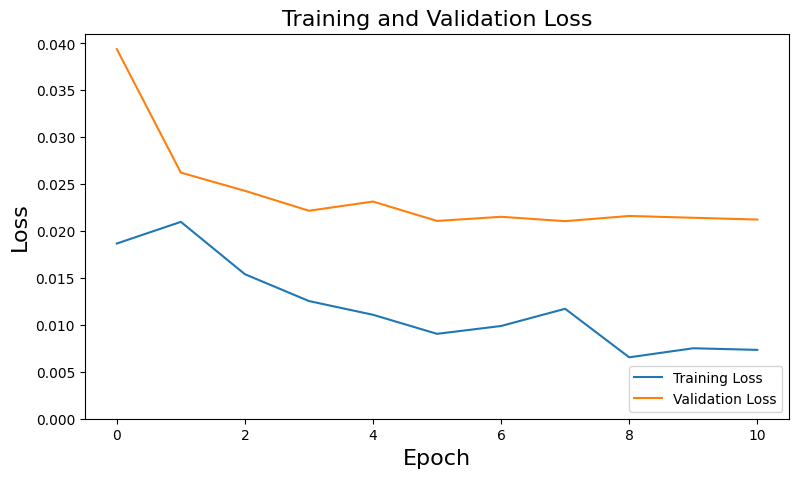

In [ ]:

#------------------------
#Loss Grafik
#------------------------
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)

In [ ]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("\nTest loss: %.1f%%"%(100.0*loss))

47/47 [==============================] - 0s 4ms/step - loss: 0.0212

Test loss: 2.1%


In [ ]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 5ms/step


In [ ]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [ ]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)



In [ ]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [ ]:
#Train Veri Seti ait RMSE Değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
#Test Veri Seti ait RMSE Değeri
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [ ]:
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:23.10973358154297
Test RMSE:46.770809173583984


In [ ]:
train_prediction_df=result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,127.172844
1949-03-01,132.0,130.426208
1949-04-01,129.0,142.281296
1949-05-01,121.0,139.437607
1949-06-01,135.0,132.268188


In [ ]:
test_prediction_df=result_df[lookback+position:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()


,Passengers,Predicted
Month,,
1957-02-01,301.0,328.143799
1957-03-01,356.0,321.285400
1957-04-01,348.0,365.330261
1957-05-01,355.0,357.747192
1957-06-01,422.0,364.382416


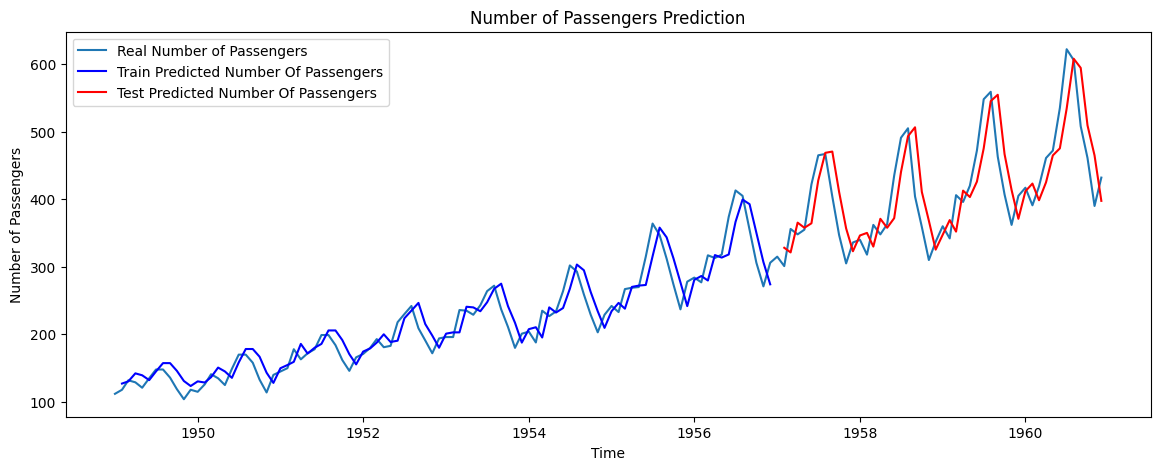

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Number of Passengers")
plt.plot(train_prediction_df["Predicted"],color='blue',label='Train Predicted Number Of Passengers')
plt.plot(test_prediction_df["Predicted"],color='red',label='Test Predicted Number Of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()